In [1]:
# Decision Tree for 400mM ethanol
# Conny Lin | May 19, 2020
# ------------------------------------
# Try KNN:
#     X = curve and another measure from drunkposture2.dat
#     y = 0mM(0) or 400mM(1) 
# ------------------------------------
# - load drunkposture2.csv
# - use curve and speed data
# - run through class' exercise KNN

In [2]:
# define local variables
dir_save = '/Users/connylin/Dropbox/CA/ED _20200119 Brain Station Data Science Diploma/Capstone/data'
path_MWTDBcsv = '/Volumes/COBOLT/MWT/MWTDB.csv'
fname_data = 'drunkposture2_90s_95s_mean_KNN.csv'
output_csv_name = 'SVM_ethanol.csv'
output_pickle_name = 'SVM_ethanol.pickle'

In [3]:
import os
import glob
import pickle
from pathlib import PurePath
import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree

In [4]:
def PlotBoundaries(model, X, Y, plotsize=(6,4)) :
    '''
    Helper function that plots the decision boundaries of a model and data (X,Y)
    code modified from: https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
    '''
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1,X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=plotsize)
    plt.contourf(xx, yy, Z, alpha=0.4)

    #Plot
    plt.scatter(X[:, 0], X[:, 1], c=Y,s=20, edgecolor='k')
    plt.show()

In [5]:
# load csv
df = pd.read_csv(os.path.join(dir_save, fname_data))
# take out nan values
df_clean = df.dropna(axis=0)

In [6]:
# get y (ethanol or not)
df_y = pd.DataFrame(list(map(lambda x: list(x.parts), 
                           list(map(PurePath, df_clean['mwtpath'])))), 
                  columns=['remove','volume','drivename','dbname','expname','groupname','mwtname'])
# set y for ML
y = df_y['groupname'].values
y[y == 'N2']=0
y[y == 'N2_400mM']=1
y = y.astype(int)

In [7]:
# get X df
df_X = df_clean[['curve','speed']]
df_X

,curve,speed
0,28.449153,0.113420
1,29.313821,0.172995
2,29.772973,0.249895
3,28.430702,0.213376
4,29.189655,0.281259
...,...,...
1652,35.568293,0.103487
1653,34.120000,0.072112
1654,28.308065,0.226469
1655,18.783065,0.124908


In [8]:
# scaling - use standard scaler
from sklearn.preprocessing import StandardScaler # 1. Import the scaler
# 2. make a scaler
my_standard_scaler = StandardScaler()
# 3. fit the scaler
my_standard_scaler.fit(df_X)
# 4. transform the data. Notice we get back a numpy array even if we put in a dataframe
scaled_loans_data = my_standard_scaler.transform(df_X)

scaled_df_X = pd.DataFrame(data=scaled_loans_data, columns=df_X.columns)
scaled_df_X.head()

# transform to array for ML
X = np.array(scaled_df_X)
X

array([[ 0.35658477, -0.84877466],
       [ 0.47722555,  0.19435336],
       [ 0.54128758,  1.54082901],
       ...,
       [ 0.33689981,  1.13066345],
       [-0.99205255, -0.64762968],
       [-1.67130841, -0.25894486]])

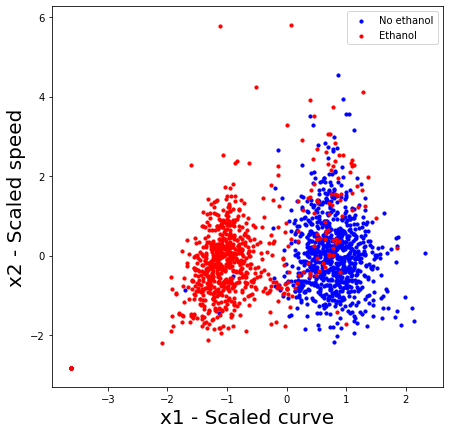

In [9]:
# plot data
group_mask = y == 0
plt.figure(figsize=(7,7))
plt.scatter(scaled_df_X["curve"][group_mask], 
            scaled_df_X["speed"][group_mask], 
            c = "blue",
            s=10,
            label="No ethanol")
plt.scatter(scaled_df_X["curve"][~group_mask], 
            scaled_df_X["speed"][~group_mask], 
            c = "red",
            s=10,
            label="Ethanol")
# plt.xlim(-2.0, 2.0)
# plt.ylim(-2.0, 2.0)
plt.legend(loc="upper right")
plt.xlabel("x1 - Scaled curve", fontsize="20")
plt.ylabel("x2 - Scaled speed", fontsize="20")
plt.show();

In [10]:
def SVM_test_parameters(X,y,testdatasplit=.8,n_random_state=1,cvalue=1,n_max_iter=100000,printopt=1):
    from sklearn.svm import LinearSVC
    # Split our data into train & test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=testdatasplit, 
                                                        random_state=n_random_state)
    # Instantiate the model & fit it to our data
    MLmodel = LinearSVC(C=cvalue, max_iter=n_max_iter)
    MLmodel.fit(X_train, y_train)
    # Score the model on the test set
    train_score = MLmodel.score(X_train,y_train)
    test_score = MLmodel.score(X_test,y_test)
    # print
    if printopt==1:
        print(f"The TRAIN accuracy is:  {train_score:.5f}")
        print(f"The TEST accuracy is:  {test_score:.5f}")
    return MLmodel, test_score, train_score

In [16]:
# generate c value
cvalue_exp_list = range(-5,5)
cvalue_list = []
for c in cvalue_exp_list:
    if c!=0:
        cvalue_list.append(c)

# set variables
testsize_list =[0.5]
n_random_state = 1
printopt = 1
class_names_set = ['No ethanol','ethanol']
n_max_iter = 100000

# run
from sklearn.svm import LinearSVC
ML_capture = []
ML_performance = []
for testdatasplit, cvalue in itertools.product(testsize_list,cvalue_list):
    # print status
    print(f'test data: {testdatasplit*100:.0f}% \tmax split: {cvalue}')
    MLmodel, test_score, train_score = SVM_test_parameters(X,y,
                                                           testdatasplit,
                                                           n_random_state,
                                                           10**cvalue,
                                                           n_max_iter,
                                                           printopt)
    # print
    if printopt==1:
        print(f"The TRAIN accuracy is:  {train_score:.5f}")
        print(f"The TEST accuracy is:  {test_score:.5f}")
    # put in memory
    ML_capture.append(MLmodel)
    ML_performance.append([testdatasplit, cvalue, train_score, test_score]) 

test data: 50% 	max split: -5
The TRAIN accuracy is:  0.92857
The TEST accuracy is:  0.92980
The TRAIN accuracy is:  0.92857
The TEST accuracy is:  0.92980
test data: 50% 	max split: -4
The TRAIN accuracy is:  0.92857
The TEST accuracy is:  0.92611
The TRAIN accuracy is:  0.92857
The TEST accuracy is:  0.92611
test data: 50% 	max split: -3
The TRAIN accuracy is:  0.93103
The TEST accuracy is:  0.92488
The TRAIN accuracy is:  0.93103
The TEST accuracy is:  0.92488
test data: 50% 	max split: -2
The TRAIN accuracy is:  0.92488
The TEST accuracy is:  0.91872
The TRAIN accuracy is:  0.92488
The TEST accuracy is:  0.91872
test data: 50% 	max split: -1
The TRAIN accuracy is:  0.91872
The TEST accuracy is:  0.91995
The TRAIN accuracy is:  0.91872
The TEST accuracy is:  0.91995
test data: 50% 	max split: 1
The TRAIN accuracy is:  0.91995
The TEST accuracy is:  0.91749
The TRAIN accuracy is:  0.91995
The TEST accuracy is:  0.91749
test data: 50% 	max split: 2
The TRAIN accuracy is:  0.91995
The 

/Users/connylin/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


The TRAIN accuracy is:  0.91872
The TEST accuracy is:  0.91749
The TRAIN accuracy is:  0.91872
The TEST accuracy is:  0.91749
test data: 50% 	max split: 4
The TRAIN accuracy is:  0.91872
The TEST accuracy is:  0.91995
The TRAIN accuracy is:  0.91872
The TEST accuracy is:  0.91995


/Users/connylin/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [18]:
# put in table
ML_accuracy_results=pd.DataFrame(ML_performance, columns=['test_size','c_value exp','train_score', 'test_score'])
display(ML_accuracy_results)

,test_size,c_value exp,train_score,test_score
0,0.5,-5,0.928571,0.929803
1,0.5,-4,0.928571,0.926108
2,0.5,-3,0.931034,0.924877
3,0.5,-2,0.924877,0.918719
4,0.5,-1,0.918719,0.919951
5,0.5,1,0.919951,0.917488
6,0.5,2,0.919951,0.917488
7,0.5,3,0.918719,0.917488
8,0.5,4,0.918719,0.919951


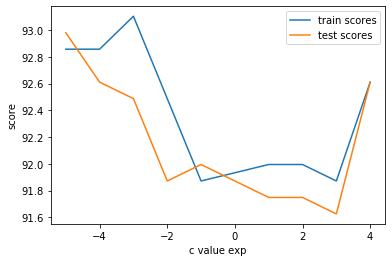

In [17]:
# display
plt.figure()
plt.plot(cvalue_list,ML_accuracy_results['train_score']*100,label='train scores')
plt.plot(cvalue_list,ML_accuracy_results['test_score']*100,label='test scores')
plt.xlabel('c value exp')
plt.ylabel('score')
# plt.xlim(90,100)
# plt.ylim(90,100)
# plt.scatter(ML_accuracy_results['c_value'],ML_accuracy_results['test_score'],label='test scores')
plt.legend()
plt.show()

In [19]:
# store data
with open(os.path.join(dir_save,output_pickle_name),'wb') as f:
    pickle.dump(ML_accuracy_results, f)
    pickle.dump(ML_capture, f)
# print complete
print('complete')

complete


AssertionError: break